In [3]:
import re
import tweepy
import pprint
import pandas as pd
import json
import pymysql
import time
import random
from http.client import IncompleteRead
import matplotlib.pyplot as plt
# -*- coding: utf-8 -*-

db = pymysql.connect("localhost", 'root','','twitter', autocommit = True)
cursor = db.cursor()

access_token = '****************************'
access_token_secret = '****************************'
bearer_token = '****************************'

consumer_key = '****************************'
consumer_secret = '****************************'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Coordinate Box

In [4]:
city = {
    "New York" : [-74.46671,40.95709,-73.49167,40.43650],
    "Tokyo" : [138.98135,35.98356,139.95639,35.42599],
    "Hong Kong" : [113.67416,22.66978,114.64920,22.03473],
    "Shen Zhen" : [113.67554,22.87744,114.65057,22.24334],
    "Los Angeles" : [-118.74856,34.33436,-117.77352,33.76545],
    "Paris" : [2.22920,48.91325,2.47296,48.80031],
    "Chicago" : [-88.18037,42.10637,-87.20533,41.59491],
    "Seoul" : [126.73004,37.70121,127.21756,37.42907],
    "Rhine-Ruhr" : [6.16882,51.94426,8.11890,51.08972],
    "Osaka" : [135.26229,34.80309,135.74981,34.52070],
    "Kobe" : [135.26229,34.80309,135.74981,34.52070],
    "Shanghai" : [120.52288,31.72116,122.47295,30.54570],
    "Dallas" : [-97.03194,32.90438,-96.54442,32.61567],
    "Washington" : [-77.25380,39.04852,-76.76628,38.78139],
    "Beijing" : [115.91537,40.12639,116.89041,39.59934],
    "San Francisco" : [-122.54807,37.82551,-122.30431,37.68980],
    "Houston" : [-95.83518,30.04176,-94.86014,29.44558],
    "Philadelphia" : [-75.38544,40.11169,-74.89792,39.84861],
    "Boston" : [-71.18556,42.38746,-70.94181,42.26054],
    "Atlanta" : [-84.66408,33.90974,-84.17656,33.62434],
    "Nagoya" : [136.68297,35.28318,137.17049,35.00244],
}
city_list = []
for i in city:
    city[i][1], city[i][3] = city[i][3], city[i][1]
    city_list.extend(city[i])

Getting tweets in the box area

In [ ]:
user_id = []
sql = "INSERT INTO `distinct_tweet` (`user_id`, `tweet_id`, `text`, `location`) VALUES (%s, %s, %s, %s)"

def find_location(data):
    c = city.keys()
    data_city = data['place']["name"]
    if data_city in c:
        return data_city
    else:
        coordinate = data['place']['bounding_box']['coordinates'][0]
        for i in coordinate:
            for j in c:
                if i[0] > city[j][0] and i[0] < city[j][2] and i[1] < city[j][1] and i[1] > city[j][3]:
                    return j
        return False
                    


class StdOutListener(tweepy.StreamListener):
    def on_data(self, data):
        try:
            data = json.loads(data)
            ids = data['user']['id']
            location = find_location(data)
            text = data['text']
            tweet_id = data['id']
            if location == False or ids in user_id:
                return True
            user_id.append(data['user']['id'])
            cursor.execute(sql, (ids, tweet_id, text, location))
            return True
        except:
            print('except')
            pass
            
    def on_exception(self, exception):
        print('exception')
        return

    def on_error(self, status):
        print(status)

l = StdOutListener()
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
stream = tweepy.Stream(auth, l)
stream.filter(locations=city_list)

Extracting user's timeline by user_id with a maximum of 3200 tweets

In [ ]:
df = pd.read_sql('SELECT * FROM `distinct_tweet` group by user_id having COUNT(*) = 1', db)
print('Data Read')

user_ids = df['user_id']
location = df['location']
sql2 = "INSERT INTO `distinct_tweet` (`user_id`, `tweet_id`, `text`, `location`, `time`) VALUES (%s, %s, %s, %s, %s)"
for i in range(len(user_ids)):
    print('Processing %d/%d'%(i+1, len(user_ids)))
    loop_control = True
    while loop_control:
        try:
            cursor_tw = tweepy.Cursor(api.user_timeline, user_ids[i], tweet_mode='extended', exclude_replies=True, include_rts=False)
            loop_control = False
        except TweepError:
            time.sleep(90)
            loop_control = True
        except:
            time.sleep(10)
            loop_control = True
    loop_control2 = True
    for j in range(6):
        try:
            for tweet in cursor_tw.items():
                cursor.execute(sql2, (int(user_ids[i]), tweet.id, tweet.full_text, location[i], tweet.created_at.strftime("%Y-%m-%d")))
            break
        except:
            time.sleep(10)
            api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            cursor_tw = tweepy.Cursor(api.user_timeline, user_ids[i], tweet_mode='extended', exclude_replies=True, include_rts=False)

Analyze sentiment score using Google Cloud Platform.

In [ ]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
df = pd.read_sql('select * from `distinct_tweet` where sentiment is null', db)
fail_list = []
# Instantiates a client
client = language.LanguageServiceClient.from_service_account_json("./My First Project-***********.json")
client2 = language.LanguageServiceClient.from_service_account_json("./testing-***********.json")
client3 = language.LanguageServiceClient.from_service_account_json("./My First Project-***********.json")
sql3 = "update distinct_tweet set text = %s, sentiment = %s where id = %s"
# The text to analyze
for i in range(len(df)):
    if i % 1000 == 0:
        print('Processing %s/%s'%(i, len(df)))
    try:
        if df['sentiment'] is not None and i%24 in range(7):
            text = re.sub(r"(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|^rt|http.+?", "", df['text'][i])
            document = types.Document(
                content=text,
                type=enums.Document.Type.PLAIN_TEXT)

            # Detects the sentiment of the text
            sentiment = client.analyze_sentiment(document=document).document_sentiment
            score  = sentiment.score
            cursor.execute(sql3, (text, score, int(df['id'][i])))

        if df['sentiment'] is not None and i%24 in range(7, 12):
            text = re.sub(r"(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|^rt|http.+?", "", df['text'][i])
            document = types.Document(
                content=text,
                type=enums.Document.Type.PLAIN_TEXT)

            # Detects the sentiment of the text
            sentiment = client2.analyze_sentiment(document=document).document_sentiment
            score  = sentiment.score
            cursor.execute(sql3, (text, score, int(df['id'][i])))

        if df['sentiment'] is not None and i%24 in range(12, 24):
            text = re.sub(r"(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|^rt|http.+?", "", df['text'][i])
            document = types.Document(
                content=text,
                type=enums.Document.Type.PLAIN_TEXT)

            # Detects the sentiment of the text
            sentiment = client3.analyze_sentiment(document=document).document_sentiment
            score  = sentiment.score
            cursor.execute(sql3, (text, score, int(df['id'][i])))
    except:
        fail_list.append(i)

Read finalized data 

In [5]:
df = pd.read_sql('select * from `distinct_tweet`', db)

See what we have got

Tweet count by location

In [6]:
df_temp = pd.read_sql('select location, count(*) from `distinct_tweet` group by location', db)
df_temp = df_temp.sort_values(by='count(*)')
print(df_temp)

         location  count(*)
12          Seoul        56
5       Hong Kong      3024
13       Shanghai      6485
1         Beijing      9926
2          Boston     27733
10   Philadelphia     29325
8        New York     29745
0         Atlanta     31913
4          Dallas     35848
6         Houston     42244
9           Paris     43156
14     Washington     62857
3         Chicago    111941
11  San Francisco    140958
7     Los Angeles    246815


Text(0.5, 1.0, 'Number of tweets collected by city')

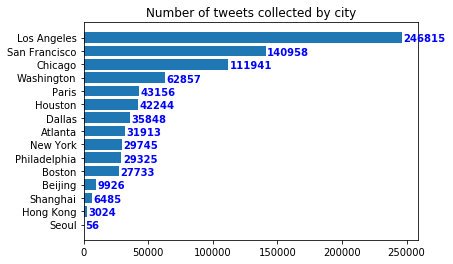

In [7]:
fig, ax = plt.subplots()  
plt.barh(range(0,15), df_temp['count(*)'], tick_label =df_temp['location'])
for i, v in enumerate(df_temp['count(*)']):
    ax.text(v+1000, i-0.3, str(v), color='blue', fontweight='bold')
plt.title('Number of tweets collected by city')

Distribution of sentiment score

In [9]:
df_temp = pd.read_sql('select sentiment, count(*) from `distinct_tweet` group by sentiment', db)
print(df_temp.sort_values(by='count(*)'))

    sentiment  count(*)
1        -0.9      2082
4        -0.6      9290
2        -0.8      9357
3        -0.7      9542
5        -0.5     10361
17        0.7     10478
18        0.8     11097
6        -0.4     12473
16        0.6     14252
7        -0.3     15109
15        0.5     17279
8        -0.2     19417
19        0.9     21623
14        0.4     22730
9        -0.1     25898
13        0.3     30939
12        0.2     32047
11        0.1     36957
10        0.0     90042
0         NaN    421053


Text(0.5, 1.0, 'Distribution of sentiment score')

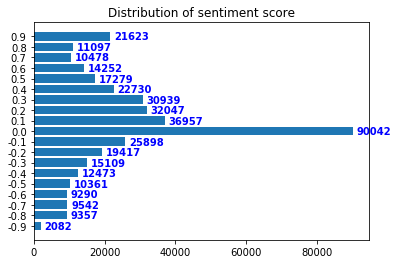

In [16]:
df_temp = df_temp[0:]
fig, ax = plt.subplots()  
plt.barh(range(len(df_temp)), df_temp['count(*)'], tick_label =df_temp['sentiment'])
for i, v in enumerate(df_temp['count(*)']):
    ax.text(v+1000, i-0.3, str(v), color='blue', fontweight='bold')
plt.title('Distribution of sentiment score')

Number of NA

In [23]:
df.isna().sum()

index             0
user_id           0
tweet_id          0
text           5391
location          0
time          32243
sentiment    421053
id                0
dtype: int64

Drop NAs

In [28]:
df = df.dropna()
df.describe()

,index,user_id,tweet_id,sentiment,id
count,364154.000000,3.641540e+05,3.641540e+05,364154.000000,364154.000000
mean,216815.040546,4.954805e+15,9.391263e+17,0.098013,216816.040546
std,106615.269566,7.106734e+16,3.439675e+17,0.404699,106615.269566
min,0.000000,9.200000e+01,2.285530e+05,-0.900000,1.000000
25%,125000.250000,3.956151e+06,7.533582e+17,-0.100000,125001.250000
50%,216795.500000,7.594782e+06,1.074655e+18,0.000000,216796.500000
75%,309106.750000,1.089570e+07,1.214235e+18,0.300000,309107.750000
max,401543.000000,1.260499e+18,1.263743e+18,0.900000,401544.000000


Analysis

Number of tweets collected by city

In [44]:
df_temp = df.groupby(['location']).size().sort_values()
df_temp

location
Beijing            1826
Hong Kong          2945
Shanghai           4757
Philadelphia      10795
Houston           10938
Boston            11523
Atlanta           12345
Dallas            12366
New York          14414
Paris             29076
Washington        35925
Chicago           42197
San Francisco     73260
Los Angeles      101787
dtype: int64

Text(0.5, 1.0, 'Number of tweets collected by city')

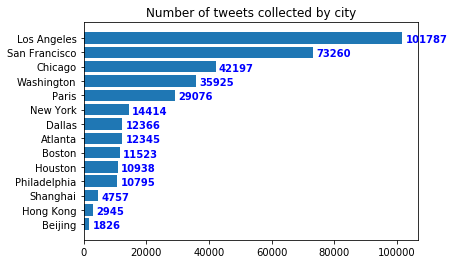

In [45]:
fig, ax = plt.subplots()  
plt.barh(range(len(df_temp)), df_temp, tick_label = df_temp.index)
for i, v in enumerate(df_temp):
    ax.text(v+1000, i-0.3, str(v), color='blue', fontweight='bold')
plt.title('Number of tweets collected by city')

Paraphrase 'time' column as data time object

In [ ]:
df['time'] = pd.to_datetime(df['time'])

Distribution of sentiment score

In [48]:
df_temp = df.groupby(['sentiment']).size()
df_temp

sentiment
-0.9     1720
-0.8     8076
-0.7     8528
-0.6     8399
-0.5     9456
-0.4    11477
-0.3    13933
-0.2    17992
-0.1    24186
 0.0    79243
 0.1    34434
 0.2    29645
 0.3    27890
 0.4    20996
 0.5    15976
 0.6    13191
 0.7     9563
 0.8    10131
 0.9    19318
dtype: int64

Text(0.5, 1.0, 'Distribution of sentiment score')

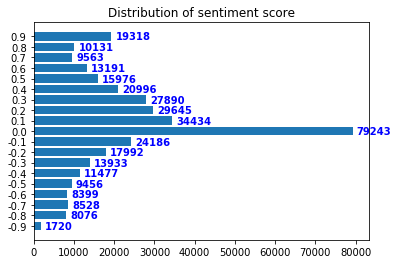

In [49]:
fig, ax = plt.subplots()  
plt.barh(range(len(df_temp)), df_temp, tick_label =df_temp.index)
for i, v in enumerate(df_temp):
    ax.text(v+1000, i-0.3, str(v), color='blue', fontweight='bold')
plt.title('Distribution of sentiment score')

Distribution of time

In [53]:
df_temp = df.groupby(['time']).size()
df_temp

time
2006-11-25       1
2006-11-27       1
2006-12-05       1
2006-12-09       7
2006-12-10       5
              ... 
2020-05-18     936
2020-05-19    1537
2020-05-20     998
2020-05-21     802
2020-05-22      79
Length: 4562, dtype: int64

Text(0.5, 1.0, 'Distribution of time')

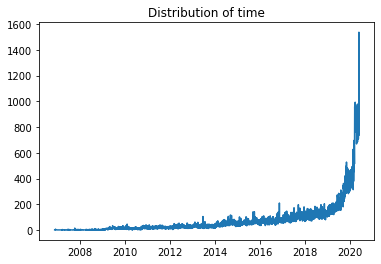

In [65]:
#fig, ax = plt.subplots()  
#plt.bar(range(len(df_temp)), df_temp, tick_label =df_temp.index)
plt.plot(df_temp[:-1])
plt.title('Distribution of time')

Select tweets posted after 2018-01-01

In [73]:
df = df.loc[df.time >= pd.to_datetime('2018-1-1')].sort_values(by='time')

Mean of sentiment by time

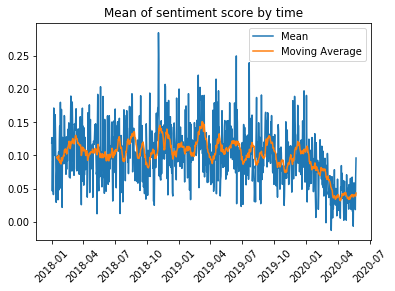

In [115]:
plt.plot(df.groupby(['time'])['sentiment'].agg('mean'), label = 'Mean')
plt.xticks(rotation=45)
plt.plot(df.groupby(['time'])['sentiment'].agg('mean').rolling(window=15).mean()[15:], label = 'Moving Average')
plt.title('Mean of sentiment score by time')
plt.legend()

In [176]:
senti_mean = df.groupby(['time'])['sentiment'].agg('mean').to_list()
print('Mean across all time:', np.mean(senti_mean))
print('Mean in 01/02/2020 - 22/05/2020:', np.mean(senti_mean[-112:]))
print('Change in percentage: {:.3%}'.format((np.mean(senti_mean[-143:])-np.mean(senti_mean))/np.mean(senti_mean)))

Mean across all time: 0.09971468172094394
Mean in 01/02/2020 - 22/05/2020: 0.048994226910613684
Change in percentage: -43.340%


Variance of sentiment by time

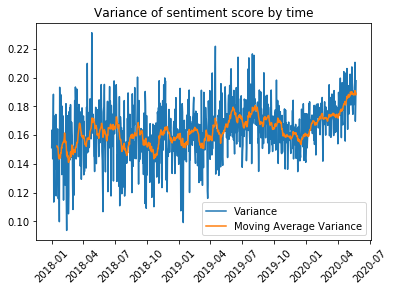

In [117]:
plt.plot(df.groupby(['time'])['sentiment'].agg('var'), label = 'Variance')
plt.xticks(rotation=45)
plt.plot(df.groupby(['time'])['sentiment'].agg('var').rolling(window=15).mean()[15:], label = 'Moving Average Variance')
plt.title('Variance of sentiment score by time')
plt.legend()

In [132]:
senti_mean = df.groupby(['time'])['sentiment'].agg('var').to_list()
print('Variance across all time:', np.mean(senti_mean))
print('Variance in 01/02/2020 - 22/05/2020:', np.mean(senti_mean[-112:]))
print('Change in percentage: {:.3%}'.format((np.mean(senti_mean[-112:])-np.mean(senti_mean))/np.mean(senti_mean)))

Variance across all time: 0.16357646308692617
Variance in 01/02/2020 - 22/05/2020: 0.1789496031798595
Change in percentage: 9.398%


Sentiment in China

In [166]:
df_1 = df.loc[df.location=='Hong Kong'].sort_values(by='time')
df_2 = df.loc[df.location=='Beijing'].sort_values(by='time')
df_3 = df.loc[df.location=='Shanghai'].sort_values(by='time')
df_China = df_1.append(df_2.append(df_3)).sort_values(by='time')

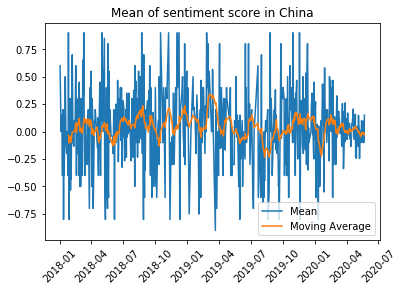

In [168]:
plt.plot(df_China.groupby(['time'])['sentiment'].agg('mean'), label = 'Mean')
plt.xticks(rotation=45)
plt.plot(df_China.groupby(['time'])['sentiment'].agg('mean').rolling(window=15).mean()[15:], label = 'Moving Average')
plt.title('Mean of sentiment score in China')
plt.legend()

In [171]:
senti_mean = df_China.groupby(['time'])['sentiment'].agg('mean').to_list()
print('Mean in China:', np.mean(senti_mean))
print('Mean in China in 01/01/2020 - 22/05/2020:', np.mean(senti_mean[-143:]))
print('Change in percentage: {:.3%}'.format((np.mean(senti_mean[-143:])-np.mean(senti_mean))/np.mean(senti_mean)))

Mean in China: 0.03974320843311348
Mean in China in 01/02/2020 - 22/05/2020: 0.010805587045253948
Change in percentage: -72.811%


Sentiment in France

In [188]:
df_France = df.loc[df.location=='Paris'].sort_values(by='time')

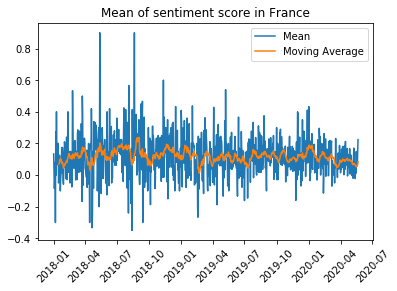

In [174]:
plt.plot(df_France.groupby(['time'])['sentiment'].agg('mean'), label = 'Mean')
plt.xticks(rotation=45)
plt.plot(df_France.groupby(['time'])['sentiment'].agg('mean').rolling(window=15).mean()[15:], label = 'Moving Average')
plt.title('Mean of sentiment score in France')
plt.legend()

In [193]:
senti_mean = df_France.groupby(['time'])['sentiment'].agg('mean').to_list()
print('Mean in France:', np.mean(senti_mean))
print('Mean in France in 01/02/2020 - 22/05/2020:', np.mean(senti_mean[-112:]))
print('Change in percentage: {:.3%}'.format((np.mean(senti_mean[-112:])-np.mean(senti_mean))/np.mean(senti_mean)))

Mean in France: 0.11744462524799545
Mean in France in 01/02/2020 - 22/05/2020: 0.0949374717444729
Change in percentage: -19.164%


Sentiment in USA

In [189]:
def condition(x): return x != 'Beijing' and x != 'Hong Kong' and x != 'Shanghai' and x != 'Paris'
df_USA = df.loc[df.location.apply(condition)].sort_values(by='time')

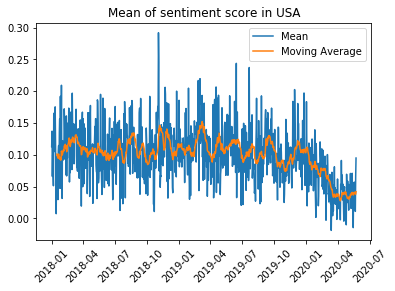

In [191]:
plt.plot(df_USA.groupby(['time'])['sentiment'].agg('mean'), label = 'Mean')
plt.xticks(rotation=45)
plt.plot(df_USA.groupby(['time'])['sentiment'].agg('mean').rolling(window=15).mean()[15:], label = 'Moving Average')
plt.title('Mean of sentiment score in USA')
plt.legend()

In [194]:
senti_mean = df_USA.groupby(['time'])['sentiment'].agg('mean').to_list()
print('Mean in France:', np.mean(senti_mean))
print('Mean in France in 01/02/2020 - 22/05/2020:', np.mean(senti_mean[-112:]))
print('Change in percentage: {:.3%}'.format((np.mean(senti_mean[-112:])-np.mean(senti_mean))/np.mean(senti_mean)))

Mean in France: 0.09955631402122345
Mean in France in 01/02/2020 - 22/05/2020: 0.04669789344917853
Change in percentage: -53.094%


What people is doing in USA during COVID-19

In [205]:
import nltk
#nltk.download('punkt')
from wordcloud import WordCloud
import wordcloud
df_Cloud = df_USA.loc[df.time >= pd.to_datetime('2020-2-1')]
text = ' '.join(nltk.word_tokenize(' '.join(df_Cloud.text)))
cloud = WordCloud(collocations=False, stopwords=wordcloud.STOPWORDS).generate(text)
cloud.to_file('usa.png')

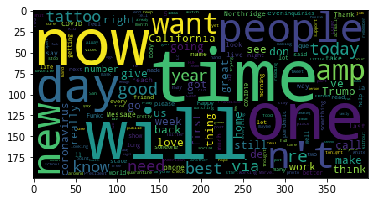

In [209]:
plt.imshow(cloud)